# Pull Data

In [2]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D
pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
plt.figure(figsize = (15, 10))
series = series[~series.isnull()]
series.plot(kind = 'line', color = 'blue')
plt.xlabel("Time")
plt.ylabel("Electricity")





Grabbing WebIDs ...
WebID collection complete!
13:30:42: Sending API request... Chunk 1 of 1
13:30:44: Response recieved for 1 tags! (1.9)


Text(0, 0.5, 'Electricity')

# Split Electricity Data Into Training + Testing

In [92]:
training_length = 0.8 * len(series)
training_length = int(round(training_length, 0))
training = series[0:training_length]
testing = series[training_length:len(series)]


# Clean Electricity Training Data

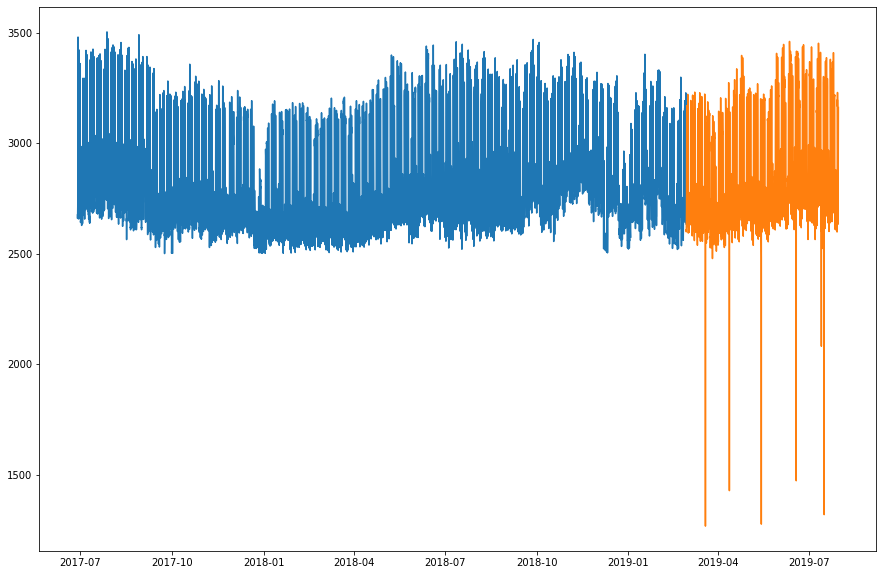

In [93]:
training = training[training.values > 2500]
plt.figure(figsize = (15, 10))
plt.plot(training.index, training.values)
plt.plot(testing.index, testing.values)

# Seasonally Decompose Data, Get Training Residuals

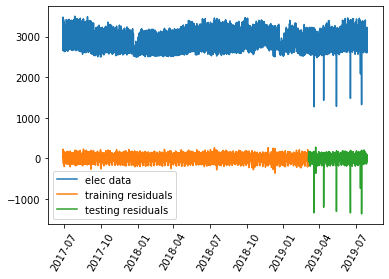

In [94]:
#decompose the training electricity data
from statsmodels.tsa.seasonal import seasonal_decompose
all_data = pd.concat([training, testing])
h = all_data.asfreq("H", method="bfill")
decomposed = seasonal_decompose(h)
resid = decomposed.resid
residuals = resid.fillna(resid.mean())
trend = decomposed.trend
trend  = trend.fillna(trend.mean())
seasonality = decomposed.seasonal
seasonality = seasonality.fillna(seasonality.mean())

#extract residuals that correspond with training
training_length = training_length + (len(h) - len(all_data))
training_residuals = residuals[0:training_length]
testing_residuals = residuals[training_length:len(residuals)]
plt.plot(h, label = 'elec data')
plt.plot(training_residuals, label = 'training residuals')
plt.plot(testing_residuals, label = 'testing residuals')
plt.xticks(rotation=60)
plt.legend(loc = 'best')
plt.show()

# Fit Best Model To The Training Residuals 

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'n_estimators': list(range(100, 1100, 100))}
gb = GradientBoostingRegressor()
grid_search = GridSearchCV(gb, param_grid, cv = 2)
x = np.array(range(len(training_residuals.index))).reshape(-1, 1)
y = training_residuals.values.reshape(-1, 1)
grid_search.fit(x, y)
best_gb = GradientBoostingRegressor(**grid_search.best_params_)
best_gb.fit(x, y)
display(grid_search.best_params_)

{'n_estimators': 100}

# Predict Future Residuals

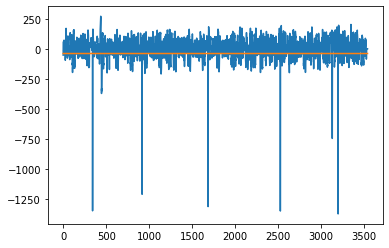

In [99]:
#index of future residuals
actual_test_set_residuals = residuals[training_length:len(residuals)]
#predicted residuals
indexes = np.array(range(training_length, len(residuals))).reshape(-1, 1)
pred_residuals = best_gb.predict(indexes)
plt.plot(actual_test_set_residuals.values, zorder=1)
plt.plot(pred_residuals, zorder=2)
HTML("Don't think this is right, needs work.")

# Add Predicted Residuals to Decomposition

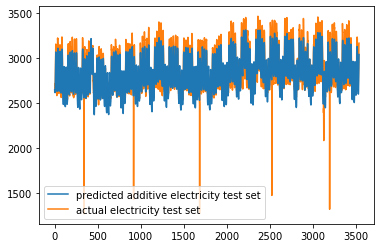

In [100]:
test_set_seasonality = seasonality[training_length:len(seasonality)]
test_set_trend = trend[training_length:len(trend)]
predicted_values = pred_residuals + test_set_seasonality + test_set_trend
actual_values = h.values[training_length:len(h)]
plt.plot(predicted_values.values, label = 'predicted additive electricity test set', zorder=2)
plt.plot(actual_values, label = 'actual electricity test set', zorder=1)
plt.legend(loc = 'best')
plt.show()


# Use IQR to identify outliers

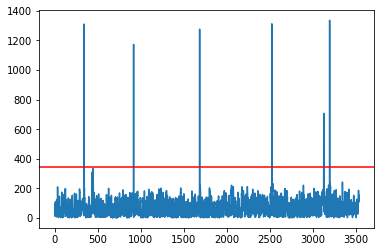

In [115]:
preds = predicted_values.values
actual = actual_values
diff = abs(actual - preds)
seventy_fifth_percentile = np.percentile(diff, 75)
twenty_fifth_percentile = np.percentile(diff, 25)
iqr = seventy_fifth_percentile - twenty_fifth_percentile
threshold = seventy_fifth_percentile + 3*iqr
plt.plot(diff)
plt.axhline(y = threshold, color = 'red')


# Extract Outliers in Test Set

Text(0.5, 1.0, 'Test Set With Outliers')

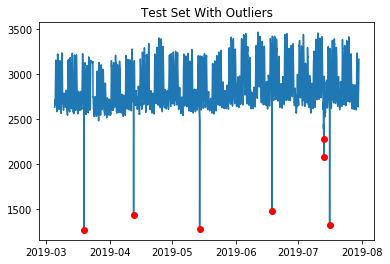

In [124]:
outlier_indexes = [i for i in range(len(diff)) if diff[i] > threshold]
actual_series = pd.Series(actual, index = predicted_values.index)
plt.plot(actual_series.index, actual_series.values)
for index in outlier_indexes:
    outlier = actual_series.values.tolist()[index]
    date = actual_series.index[index]
    plt.plot(date, outlier, marker = 'o', color = 'red')

plt.title("Test Set With Outliers")

# Clean All Elec Data, Decompose, and Save Best Model

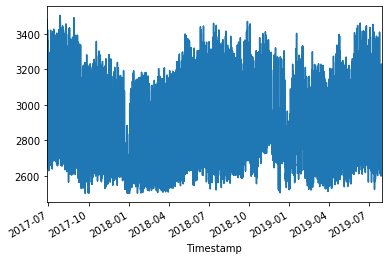

In [140]:
import pickle
cleaned_all_elec = series[series.values > 2500]
cleaned_all_elec.plot()
cleaned_all_elec = cleaned_all_elec.asfreq("H", method="bfill")
decomposed = seasonal_decompose(cleaned_all_elec)
resid = decomposed.resid.fillna(resid.mean())
x = np.array(range(len(resid.index))).reshape(-1, 1)
y = resid.values.reshape(-1, 1)
final_mod = GradientBoostingRegressor(**grid_search.best_params_)
final_mod.fit(x, y)
filename = 'finalized_gb.sav'
#save the model
pickle.dump(final_mod, open(filename, 'wb'))